# Koc University ENGR421 Fall 2020 HW7

## Onur Mavitaş

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg
import pandas as pd

## Importing Data

In [2]:
# read data into memory
training_images = np.genfromtxt("hw07_training_images.csv", delimiter = ",")
training_labels = np.genfromtxt("hw07_training_labels.csv", delimiter = ",")

test_images = np.genfromtxt("hw07_test_images.csv", delimiter = ",")
test_labels = np.genfromtxt("hw07_test_labels.csv", delimiter = ",")

# get X and y values
X = training_images / 255
y = training_labels.astype(int)

X_test = test_images / 255
y_test = test_labels.astype(int)

# get number of samples and number of features
N = X.shape[0]
D = X.shape[1]
K = 3


In [4]:
train_x_y = np.column_stack([X, y])

## Linear Discriminant Analysis

We want to find the matrix W such that z = W^T*x where z is k dimensional and W is dxk.
The within class scatter matrix
The total within class scatter matrix
The scatter of the means
The between class scatter matrix
Solution: the largest eigenvectors of inverse(S_w)*(S_B)

In [5]:
def lda(X, y):
    #within class matrix using covariance
    matrices = []
    for c in range(1,4):
        N_c = X[y==c].shape[0] #the size
        Sigma_X = np.cov(np.transpose(X[y==c])) #covariance matrix
        S_w_c = (N_c-1)*Sigma_X
        matrices.append(S_w_c)

    S_W = np.sum(matrices,0) #within class scatter matrix
    S_W.flat[::S_W.shape[1]+1] += 1e-1  #adding to the diagonals

    #between class scatter matrix using overall mean and class means
    overall_mean = np.mean(X, axis=0)
    mean_vectors = []
    for c in range(1,4):
        mean_vectors.append(np.mean(X[y==c], axis=0))

    S_B = np.zeros((784,784))
    for i,means in enumerate(mean_vectors):  
        overall_mean = overall_mean.reshape(784,1)
        means = means.reshape(784,1)
        n = X[y==i+1,:].shape[0]
        S_B += n * (means - overall_mean).dot((means - overall_mean).T)

    #the largest eigenvectors of S_W^-1S_B are the solution
    #eigenvectors form the new axes, eigenvalues show how discriminative the axes are
    eig_values, eig_vectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

    #eigvectors with the lowest eigvalues provide the least info
    eigval_vec = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))]
    eigval_vec = sorted(eigval_vec, key=lambda k: k[0], reverse=True) #eigenvalue-vector pairs sorted by eigenvalues
       
    #picking the largest eigenvectors for W
    W = np.hstack((eigval_vec[0][1].reshape(784,1), eigval_vec[1][1].reshape(784,1)))

    #transform the data points onto the new space
    Z = X.dot(W)
    return Z

In [6]:
Z = lda(X, y)

In [7]:
Z_test = lda(X_test, y_test)

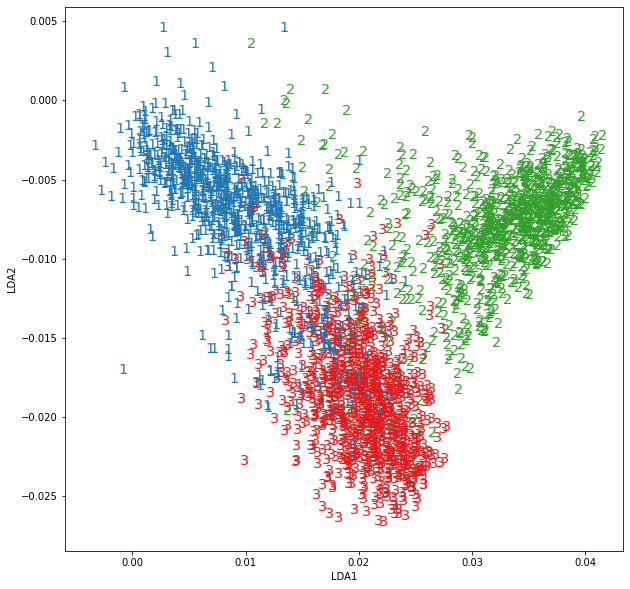

In [8]:
import warnings
warnings.filterwarnings("ignore")

def plotLDA(Z,y):
    # plot two-dimensional projections
    plt.figure(figsize = (10, 10))
    point_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c"])
    for c in range(3):
        plt.plot(Z[y == c + 1, 0], Z[y == c + 1, 1], marker = "o", markersize = 0, linestyle = "none", color = point_colors[c])
    for i in range(N):
        plt.text(Z[i, 0], Z[i, 1], y[i]%10, color = point_colors[y[i] - 1], fontsize = "x-large")
    plt.xlabel("LDA1")
    plt.ylabel("LDA2")
    plt.show()

plotLDA(Z,y)

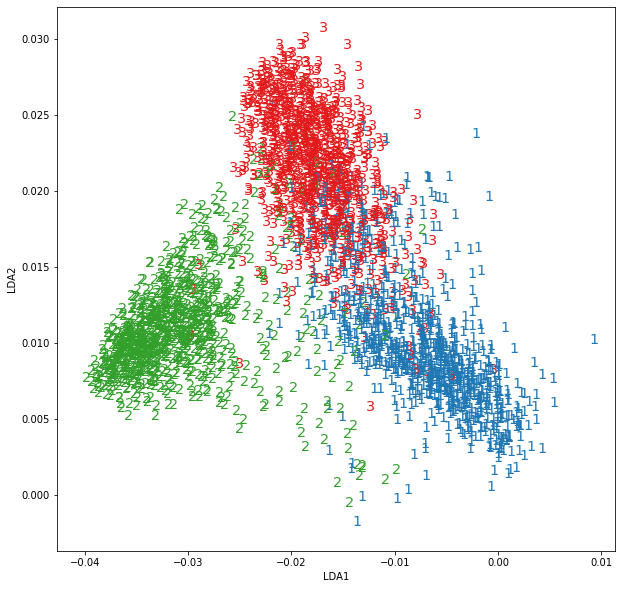

In [9]:
plotLDA(Z_test,y_test)

## 5-nearest neighbors

In [10]:
X = np.real(X)
Z = np.real(Z)
Z_test = np.real(Z_test)

In [11]:
Z.reshape(3000,2)
Z_test.reshape(3000,2)

array([[-0.00142454,  0.00840773],
       [-0.03466404,  0.00970166],
       [-0.02281591,  0.01769333],
       ...,
       [-0.01121978,  0.00927605],
       [-0.01102347,  0.00836205],
       [-0.0113393 ,  0.01020384]])

In [12]:

from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

sklearn_classifier = KNeighborsClassifier(n_neighbors=3, metric="euclidean").fit(Z, y)
sklearn_classifier_test = KNeighborsClassifier(n_neighbors=3, metric="euclidean").fit(Z, y_test)

In [13]:
pred_train = sklearn_classifier.predict(Z)
pred_test = sklearn_classifier_test.predict(Z_test)

In [14]:
confusion_matrix1 = pd.crosstab(pred_test, y_test, rownames = ['y_pred'], colnames = ['y_truth'])

In [15]:
print(confusion_matrix1)

y_truth    1    2    3
y_pred                
1        716  143  767
2         49    0    0
3        235  857  233


In [16]:
confusion_matrix2 = pd.crosstab(pred_train, y, rownames = ['y_pred'], colnames = ['y_truth'])
print(confusion_matrix2)

y_truth    1    2    3
y_pred                
1        944   20   61
2          5  927   10
3         63   27  943
